In [4]:
import os
import pandas as pd
from split_data import split_data  # assumes split_data.py is in your working dir
from tqdm import tqdm

# === List of original h5ad datasets ===
datapaths = [
    # "GSE264667_jurkat_raw_singlecell_01.h5ad", 
    # "TianKampmann2019_day7neuron.h5ad",
    "ReplogleWeissman2022_rpe1.h5ad",
    # "ReplogleWeissman2022_K562_essential.h5ad",
    # "GSE264667_hepg2_raw_singlecell_01.h5ad",
    # "NormanWeissman2019_filtered.h5ad",
    # "FrangiehIzar2021_RNA.h5ad",
    # "TianKampmann2021_CRISPRi.h5ad",
    # "TianKampmann2021_CRISPRa.h5ad",
    # "TianKampmann2019_iPSC.h5ad"
]

# === Where to save the split directories ===
split_output_base = "./split_outputs"  # ← you can change this

# === Parameters ===
n_splits = 10
seed = 42
qc_flag = False  # change to True if you want to apply QC
dry_run = False  # change to True to just print log without saving

# === Loop over all datasets and generate splits ===
os.makedirs(split_output_base, exist_ok=True)
all_summaries = []

for data_path in tqdm(datapaths):
    summary = split_data(
        adata_p=data_path,
        data_dir=split_output_base,
        n_splits=n_splits,
        seed=seed,
        out_file_name='perturb_processed.h5ad',
        qc=qc_flag,
        dry=dry_run
    )
    summary["dataset"] = os.path.basename(data_path).replace(".h5ad", "")
    all_summaries.append(summary)

# === Save overall summary ===
full_summary_df = pd.concat(all_summaries, ignore_index=True)
full_summary_df.to_csv(os.path.join(split_output_base, "all_split_summaries.csv"), index=False)
print("✅ All splits generated and summary saved.")


  0%|                                                     | 0/1 [00:00<?, ?it/s]2025-07-30 10:25:19,720 - INFO - Reading dataset: ReplogleWeissman2022_rpe1.h5ad
2025-07-30 10:25:40,490 - INFO - Full matrix (pre-filtering) sparsity: 60.01% (1301685946 of 2168999586 zero entries)


Perturbations (cleaned): ['MRPS31' 'LRRC37A3' 'SRCAP' ... 'NUP93' 'RPS16' 'CCNA2']
784 perturbations
3463 genes after filtering
shapes X0, X1: (11485, 3463) (155, 3463)


2025-07-30 10:26:00,257 - INFO - Full matrix (post-filtering) sparsity: 39.66% (226355874 of 570754345 zero entries)
2025-07-30 10:26:00,298 - INFO - X0 (control) sparsity: 39.18% (15584726 of 39772555 zero entries)
2025-07-30 10:26:00,299 - INFO - X1 (perturbation) sparsity: 37.94% (203654 of 536765 zero entries)
2025-07-30 10:26:00,353 - INFO - Creating split 0 with shape: (25581, 3463) and #perturbations: 80
... storing 'perturbation_base' as categorical
2025-07-30 10:26:06,827 - INFO - Creating split 1 with shape: (41866, 3463) and #perturbations: 159
... storing 'perturbation_base' as categorical
2025-07-30 10:26:16,081 - INFO - Creating split 2 with shape: (57282, 3463) and #perturbations: 238
... storing 'perturbation_base' as categorical
2025-07-30 10:26:29,138 - INFO - Creating split 3 with shape: (72160, 3463) and #perturbations: 316
... storing 'perturbation_base' as categorical
2025-07-30 10:26:44,934 - INFO - Creating split 4 with shape: (89407, 3463) and #perturbations: 3

✅ All splits generated and summary saved.


In [5]:
pwd

'/Users/bdk6456/Documents/CIPHER/LR/CPA_comparison'

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import anndata as ad
from scipy.sparse import issparse
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os, time
import pandas as pd
import psutil


# Ensure CPU only
device = torch.device("cpu")


# === Dataset Definition ===
class CPA_PairedDataset(Dataset):
    def __init__(self, x_control, x_pert, y_onehot, y_int):
        self.x_control = x_control
        self.x_pert = x_pert
        self.y_onehot = y_onehot
        self.y_int = y_int

    def __len__(self):
        return len(self.x_pert)

    def __getitem__(self, idx):
        control_idx = np.random.randint(0, len(self.x_control))
        return self.x_control[control_idx], self.x_pert[idx], self.y_onehot[idx], self.y_int[idx]


# === Data Loader ===
def get_data_for_cpa_training(data_path, expression_threshold=1.0, min_samples=100):
    adata = ad.read_h5ad(data_path)
    adata.obs['perturbation_base'] = adata.obs['perturbation'].str.replace(r'g\d+$', '', regex=True)
    all_perts = adata.obs['perturbation_base'].unique()

    gene_means = adata.X.mean(axis=0).A1 if issparse(adata.X) else adata.X.mean(axis=0)
    valid_genes = np.where(gene_means >= expression_threshold)[0]
    gene_names_to_keep = set(adata.var_names[valid_genes]) | set(all_perts)
    adata = adata[:, adata.var_names.isin(gene_names_to_keep)]

    perturbation_counts = adata.obs['perturbation'].value_counts()
    valid_perts = perturbation_counts[perturbation_counts >= min_samples].index.tolist()
    adata = adata[adata.obs['perturbation'].isin(valid_perts)]

    control_mask = adata.obs['perturbation'] == 'control'
    perturbed_mask = ~control_mask
    control_data = adata[control_mask]
    perturbed_data = adata[perturbed_mask]

    X0 = control_data.X.toarray() if issparse(control_data.X) else control_data.X
    X1 = perturbed_data.X.toarray() if issparse(perturbed_data.X) else perturbed_data.X
    y_labels = perturbed_data.obs['perturbation'].values

    encoder = OneHotEncoder(sparse_output=False)
    y_onehot = encoder.fit_transform(y_labels.reshape(-1, 1))
    pert_label_list = encoder.categories_[0]

    return torch.tensor(X0, dtype=torch.float32), \
           torch.tensor(X1, dtype=torch.float32), \
           torch.tensor(y_onehot, dtype=torch.float32), \
           y_labels, pert_label_list


# === VAE Components ===
class GaussianEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.shared = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.LayerNorm(hidden_dim),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.LayerNorm(hidden_dim)
        )
        self.fc_mu = torch.nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = torch.nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = self.shared(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std, mu, logvar


class SimpleCPA_VAE(torch.nn.Module):
    def __init__(self, gene_dim, pert_dim, hidden_dim=256, latent_dim=64, decode_hidden_dim=256):
        super().__init__()
        self.encoder_basal = GaussianEncoder(gene_dim, hidden_dim, latent_dim)
        self.encoder_perturb = GaussianEncoder(pert_dim, hidden_dim, latent_dim)
        self.classifier = torch.nn.Linear(latent_dim, pert_dim)
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, decode_hidden_dim),
            torch.nn.ReLU(),
            torch.nn.LayerNorm(decode_hidden_dim),
            torch.nn.Linear(decode_hidden_dim, decode_hidden_dim),
            torch.nn.ReLU(),
            torch.nn.LayerNorm(decode_hidden_dim),
            torch.nn.Linear(decode_hidden_dim, gene_dim)
        )

    def forward(self, x_control, y_onehot):
        z_basal, mu_basal, logvar_basal = self.encoder_basal(x_control)
        z_pert, mu_pert, logvar_pert = self.encoder_perturb(y_onehot)
        z = z_basal + z_pert
        x_pred = self.decoder(z)
        logits = self.classifier(z)
        return {
            "x_pred": x_pred,
            "logits": logits,
            "mu_basal": mu_basal,
            "logvar_basal": logvar_basal,
            "mu_pert": mu_pert,
            "logvar_pert": logvar_pert
        }


# === Losses ===
def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)


def compute_loss_jointKL(output, x_pert, y_true, alpha=1.0, beta=1.0, gamma=1.0):
    recon_loss = torch.nn.functional.mse_loss(output["x_pred"], x_pert, reduction='mean')
    cls_loss = torch.nn.functional.cross_entropy(output["logits"], y_true)
    kl = kl_divergence(output["mu_basal"], output["logvar_basal"]).mean() + \
         kl_divergence(output["mu_pert"], output["logvar_pert"]).mean()
    total = alpha * recon_loss + beta * cls_loss + gamma * kl
    return total, recon_loss.item(), cls_loss.item(), kl.item()

import resource

# === Training & Evaluation ===
def train_and_evaluate_dataset(data_path):
    print(f"=== Running on {data_path} ===")
    start_time = time.time()

    X0, X1, Y_onehot, y_str_labels, pert_label_list = get_data_for_cpa_training(data_path)
    scaler = MinMaxScaler()
    X0_np, X1_np = X0.numpy(), X1.numpy()
    scaler.fit(X0_np)
    X0 = torch.tensor(scaler.transform(X0_np), dtype=torch.float32)
    X1 = torch.tensor(scaler.transform(X1_np), dtype=torch.float32)

    label_to_index = {p: i for i, p in enumerate(pert_label_list)}
    y_int_labels = torch.tensor([label_to_index[y] for y in y_str_labels], dtype=torch.long)

    dataset = CPA_PairedDataset(X0, X1, Y_onehot, y_int_labels)
    loader = DataLoader(dataset, batch_size=10000, shuffle=True)

    model = SimpleCPA_VAE(gene_dim=X0.shape[1], pert_dim=Y_onehot.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    print('training')
    for epoch in range(20):
        model.train()
        total_loss = 0.0
        total_recon = 0.0
        total_cls = 0.0
        total_kl = 0.0
        batch_count = 0
    
        for x_control, x_pert, y_onehot, y_int in loader:
            x_control, x_pert, y_onehot, y_int = x_control.to(device), x_pert.to(device), y_onehot.to(device), y_int.to(device)
            output = model(x_control, y_onehot)
            loss, recon_loss, cls_loss, kl_loss = compute_loss_jointKL(output, x_pert, y_int)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
            total_recon += recon_loss
            total_cls += cls_loss
            total_kl += kl_loss
            batch_count += 1
    
        print(f"Epoch {epoch+1:02d} | "
              f"Total: {total_loss / batch_count:.4f} | "
              f"Recon: {total_recon / batch_count:.4f} | "
              f"Cls: {total_cls / batch_count:.4f} | "
              f"KL: {total_kl / batch_count:.4f}")


    train_time = time.time() - start_time
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # Get peak memory used by current process in GB
    # process = psutil.Process()
    # peak_memory_bytes = process.memory_info().peak_wset if hasattr(process.memory_info(), 'peak_wset') else process.memory_info().rss
    # peak_memory_GB = peak_memory_bytes / (1024 ** 3)

    # ru_maxrss is in kilobytes on macOS
    peak_memory_kb = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    peak_memory_GB = peak_memory_kb / (1024 ** 3)


    print('evaluation')
    # Evaluation
    model.eval()
    r2_scores, r2_dx_scores = [],[]
    x0_avg_unscaled = scaler.inverse_transform(X0.mean(dim=0).numpy().reshape(1, -1)).flatten()
    pert_to_indices = {p: np.where(np.array(y_str_labels) == p)[0] for p in pert_label_list if p != "control"}

    for p_idx, p in enumerate(pert_label_list):
        if p == "control" or len(pert_to_indices.get(p, [])) == 0:
            continue
        p_onehot = torch.zeros((len(X0), Y_onehot.shape[1]), device=device)
        p_onehot[:, p_idx] = 1.0
        with torch.no_grad():
            x_pred_avg = model(X0.to(device), p_onehot).get("x_pred").mean(dim=0).cpu().numpy()
        x_pred_avg_unscaled = scaler.inverse_transform(x_pred_avg.reshape(1, -1)).flatten()
        idx = pert_to_indices[p]
        x_real_avg = X1[idx].mean(dim=0).cpu().numpy()
        x_real_avg_unscaled = scaler.inverse_transform(x_real_avg.reshape(1, -1)).flatten()
        delta_true = x_real_avg_unscaled - x0_avg_unscaled
        delta_pred = x_pred_avg_unscaled - x0_avg_unscaled
        mask = delta_true != 0
        epsilon = 1e-8
        r2dx = 1.0 - np.sum((delta_pred[mask] - delta_true[mask])**2) / (np.sum(delta_true[mask]**2) + epsilon)
        r2_dx_scores.append(r2dx)
        r2 = 1.0 - np.sum((x_pred_avg_unscaled[mask] - x_real_avg_unscaled[mask])**2) / (np.sum(x_real_avg_unscaled[mask]**2) + epsilon)
        r2_scores.append(r2)

        

    # Save histogram
    plt.hist(r2_scores, bins=1000, alpha=0.75, density = True)
    plt.xlim(0,1)
    plt.title(f"R² Distribution - {os.path.basename(data_path)}")
    plt.xlabel("R²")
    plt.ylabel("Frequency")
    plt.tight_layout()
    os.makedirs("r2_distributions", exist_ok=True)
    plt.savefig(f"r2_distributions/{os.path.basename(data_path).replace('.h5ad', '')}_r2_hist.png")
    plt.show()
    plt.close()
    print('peak_memory_GB = ',peak_memory_GB)
    return {
        "dataset": os.path.basename(data_path),
        "n_parameters": params,
        "train_time_sec": train_time,
        "peak_memory_GB": peak_memory_GB,
        "all_r2": r2_scores,
        "all_r2dx": r2_dx_scores,
        "avg_r2": float(np.mean(r2_scores)),
        "avg_r2dx": float(np.mean(r2_dx_scores))
    }


# # === Run on datasets ===
# datapaths = [
#     # "TianKampmann2019_day7neuron.h5ad",
#     "ReplogleWeissman2022_rpe1.h5ad",
#     "ReplogleWeissman2022_K562_essential.h5ad"
# ]

# results = [train_and_evaluate_dataset(path) for path in datapaths]
# pd.DataFrame(results).to_csv("CPA_VAE_results_summary.csv", index=False)


  0%|                                                    | 0/10 [00:00<?, ?it/s]

=== Running on ./split_outputs/ReplogleWeissman2022_rpe1_splits/split_0/perturb_processed.h5ad ===
training
Epoch 01 | Total: 35.9351 | Recon: 0.3403 | Cls: 4.7856 | KL: 30.8093
Epoch 02 | Total: 16.7371 | Recon: 0.2943 | Cls: 4.6134 | KL: 11.8293
Epoch 03 | Total: 10.1672 | Recon: 0.2530 | Cls: 4.5653 | KL: 5.3489
Epoch 04 | Total: 8.6040 | Recon: 0.2180 | Cls: 4.5544 | KL: 3.8316
Epoch 05 | Total: 7.6892 | Recon: 0.1845 | Cls: 4.5715 | KL: 2.9332
Epoch 06 | Total: 6.7831 | Recon: 0.1537 | Cls: 4.5527 | KL: 2.0766
Epoch 07 | Total: 6.0598 | Recon: 0.1284 | Cls: 4.5296 | KL: 1.4018
Epoch 08 | Total: 5.6634 | Recon: 0.1089 | Cls: 4.5283 | KL: 1.0262
Epoch 09 | Total: 5.4831 | Recon: 0.0935 | Cls: 4.5285 | KL: 0.8611
Epoch 10 | Total: 5.3484 | Recon: 0.0810 | Cls: 4.5247 | KL: 0.7427
Epoch 11 | Total: 5.2176 | Recon: 0.0709 | Cls: 4.5141 | KL: 0.6327
Epoch 12 | Total: 5.1193 | Recon: 0.0623 | Cls: 4.5227 | KL: 0.5343
Epoch 13 | Total: 5.0006 | Recon: 0.0548 | Cls: 4.5080 | KL: 0.4379
Epo

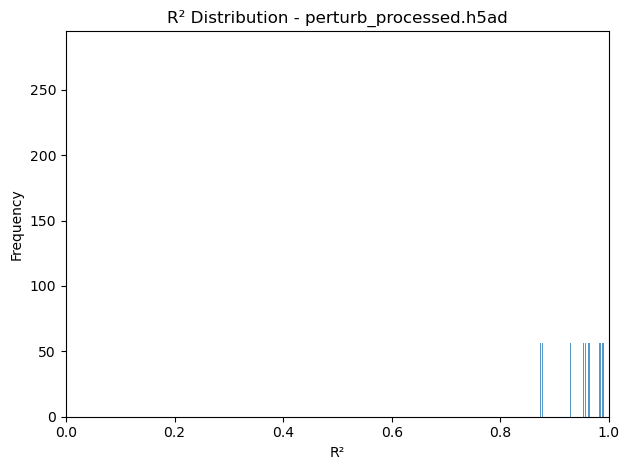

 10%|████▍                                       | 1/10 [00:15<02:19, 15.52s/it]

peak_memory_GB =  2.2358856201171875
=== Running on ./split_outputs/ReplogleWeissman2022_rpe1_splits/split_1/perturb_processed.h5ad ===
training
Epoch 01 | Total: 27.2421 | Recon: 0.3152 | Cls: 5.4285 | KL: 21.4983
Epoch 02 | Total: 10.8879 | Recon: 0.2386 | Cls: 5.2675 | KL: 5.3818
Epoch 03 | Total: 8.1030 | Recon: 0.1701 | Cls: 5.2768 | KL: 2.6561
Epoch 04 | Total: 6.6571 | Recon: 0.1192 | Cls: 5.2739 | KL: 1.2641
Epoch 05 | Total: 6.2045 | Recon: 0.0890 | Cls: 5.2618 | KL: 0.8537
Epoch 06 | Total: 5.8800 | Recon: 0.0689 | Cls: 5.2402 | KL: 0.5709
Epoch 07 | Total: 5.6924 | Recon: 0.0541 | Cls: 5.2408 | KL: 0.3974
Epoch 08 | Total: 5.5732 | Recon: 0.0425 | Cls: 5.2260 | KL: 0.3048
Epoch 09 | Total: 5.4573 | Recon: 0.0347 | Cls: 5.2042 | KL: 0.2184
Epoch 10 | Total: 5.4098 | Recon: 0.0280 | Cls: 5.1964 | KL: 0.1854
Epoch 11 | Total: 5.3709 | Recon: 0.0228 | Cls: 5.1984 | KL: 0.1496
Epoch 12 | Total: 5.3370 | Recon: 0.0197 | Cls: 5.1841 | KL: 0.1332
Epoch 13 | Total: 5.3085 | Recon: 0.

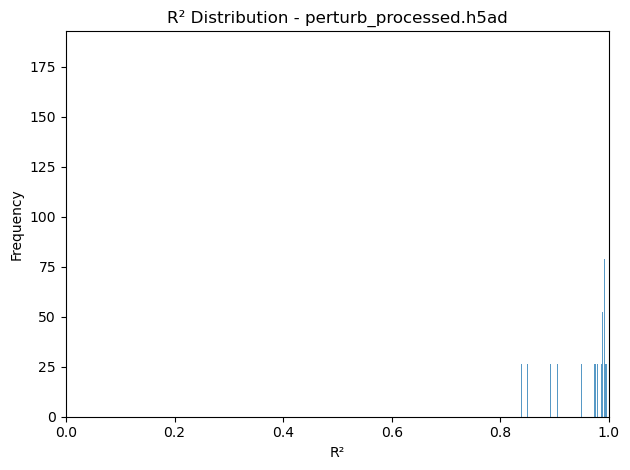

 20%|████████▊                                   | 2/10 [00:56<04:05, 30.74s/it]

peak_memory_GB =  2.2578582763671875
=== Running on ./split_outputs/ReplogleWeissman2022_rpe1_splits/split_2/perturb_processed.h5ad ===
training
Epoch 01 | Total: 25.4338 | Recon: 0.3095 | Cls: 5.8026 | KL: 19.3217
Epoch 02 | Total: 9.5570 | Recon: 0.2131 | Cls: 5.7022 | KL: 3.6416
Epoch 03 | Total: 7.3923 | Recon: 0.1387 | Cls: 5.6822 | KL: 1.5714
Epoch 04 | Total: 6.5342 | Recon: 0.0921 | Cls: 5.6666 | KL: 0.7755
Epoch 05 | Total: 6.2204 | Recon: 0.0657 | Cls: 5.6453 | KL: 0.5093
Epoch 06 | Total: 5.9901 | Recon: 0.0484 | Cls: 5.6321 | KL: 0.3096
Epoch 07 | Total: 5.8760 | Recon: 0.0363 | Cls: 5.6181 | KL: 0.2216
Epoch 08 | Total: 5.7992 | Recon: 0.0277 | Cls: 5.6074 | KL: 0.1640
Epoch 09 | Total: 5.7461 | Recon: 0.0219 | Cls: 5.5977 | KL: 0.1265
Epoch 10 | Total: 5.6980 | Recon: 0.0180 | Cls: 5.5725 | KL: 0.1075
Epoch 11 | Total: 5.6612 | Recon: 0.0155 | Cls: 5.5521 | KL: 0.0936
Epoch 12 | Total: 5.6425 | Recon: 0.0138 | Cls: 5.5432 | KL: 0.0855
Epoch 13 | Total: 5.6139 | Recon: 0.0

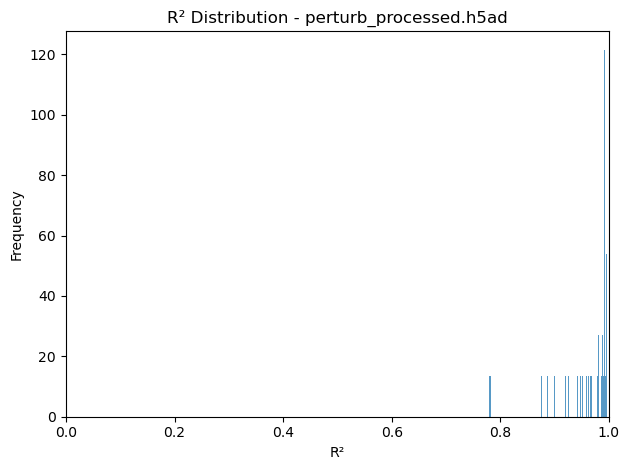

 30%|█████████████▏                              | 3/10 [01:52<04:53, 41.97s/it]

peak_memory_GB =  3.9500274658203125
=== Running on ./split_outputs/ReplogleWeissman2022_rpe1_splits/split_3/perturb_processed.h5ad ===
training
Epoch 01 | Total: 19.5427 | Recon: 0.2849 | Cls: 6.0541 | KL: 13.2037
Epoch 02 | Total: 8.2398 | Recon: 0.1596 | Cls: 6.0037 | KL: 2.0765
Epoch 03 | Total: 6.8554 | Recon: 0.0888 | Cls: 5.9770 | KL: 0.7896
Epoch 04 | Total: 6.4212 | Recon: 0.0550 | Cls: 5.9598 | KL: 0.4064
Epoch 05 | Total: 6.2062 | Recon: 0.0356 | Cls: 5.9417 | KL: 0.2288
Epoch 06 | Total: 6.0949 | Recon: 0.0239 | Cls: 5.9188 | KL: 0.1522
Epoch 07 | Total: 6.0364 | Recon: 0.0176 | Cls: 5.9070 | KL: 0.1118
Epoch 08 | Total: 5.9844 | Recon: 0.0144 | Cls: 5.8787 | KL: 0.0913
Epoch 09 | Total: 5.9594 | Recon: 0.0125 | Cls: 5.8669 | KL: 0.0801
Epoch 10 | Total: 5.9390 | Recon: 0.0115 | Cls: 5.8533 | KL: 0.0742
Epoch 11 | Total: 5.9109 | Recon: 0.0110 | Cls: 5.8293 | KL: 0.0705
Epoch 12 | Total: 5.8994 | Recon: 0.0103 | Cls: 5.8206 | KL: 0.0685
Epoch 13 | Total: 5.8795 | Recon: 0.0

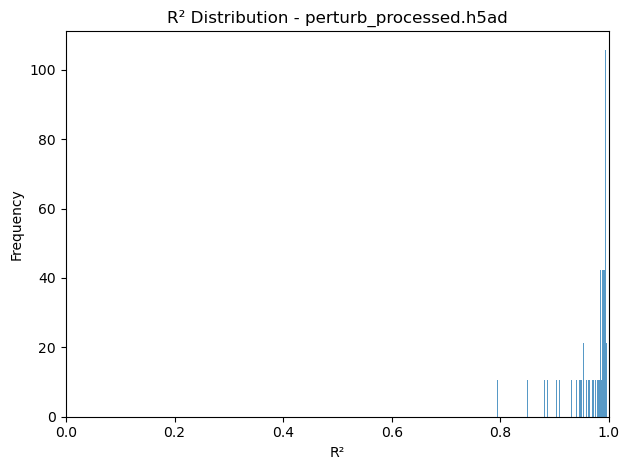

 40%|█████████████████▌                          | 4/10 [03:04<05:23, 53.95s/it]

peak_memory_GB =  5.41534423828125
=== Running on ./split_outputs/ReplogleWeissman2022_rpe1_splits/split_4/perturb_processed.h5ad ===
training
Epoch 01 | Total: 18.7737 | Recon: 0.2783 | Cls: 6.2578 | KL: 12.2376
Epoch 02 | Total: 8.0834 | Recon: 0.1429 | Cls: 6.1821 | KL: 1.7584
Epoch 03 | Total: 6.9001 | Recon: 0.0746 | Cls: 6.1694 | KL: 0.6560
Epoch 04 | Total: 6.5138 | Recon: 0.0442 | Cls: 6.1558 | KL: 0.3138
Epoch 05 | Total: 6.3402 | Recon: 0.0271 | Cls: 6.1266 | KL: 0.1865
Epoch 06 | Total: 6.2424 | Recon: 0.0187 | Cls: 6.0981 | KL: 0.1256
Epoch 07 | Total: 6.1894 | Recon: 0.0145 | Cls: 6.0776 | KL: 0.0973
Epoch 08 | Total: 6.1481 | Recon: 0.0125 | Cls: 6.0504 | KL: 0.0852
Epoch 09 | Total: 6.1177 | Recon: 0.0114 | Cls: 6.0284 | KL: 0.0780
Epoch 10 | Total: 6.0964 | Recon: 0.0107 | Cls: 6.0109 | KL: 0.0747
Epoch 11 | Total: 6.0762 | Recon: 0.0103 | Cls: 5.9934 | KL: 0.0725
Epoch 12 | Total: 6.0587 | Recon: 0.0100 | Cls: 5.9774 | KL: 0.0712
Epoch 13 | Total: 6.0466 | Recon: 0.009

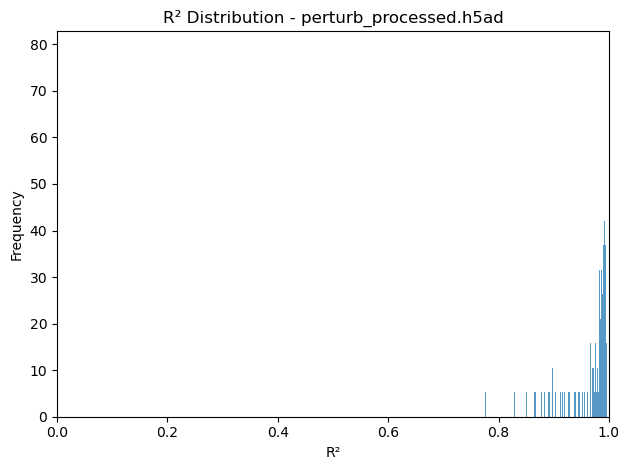

 50%|██████████████████████                      | 5/10 [04:33<05:33, 66.71s/it]

peak_memory_GB =  5.41534423828125
=== Running on ./split_outputs/ReplogleWeissman2022_rpe1_splits/split_5/perturb_processed.h5ad ===
training
Epoch 01 | Total: 18.5561 | Recon: 0.2596 | Cls: 6.4393 | KL: 11.8573
Epoch 02 | Total: 7.8289 | Recon: 0.1148 | Cls: 6.3673 | KL: 1.3468
Epoch 03 | Total: 6.8418 | Recon: 0.0567 | Cls: 6.3428 | KL: 0.4423
Epoch 04 | Total: 6.5436 | Recon: 0.0317 | Cls: 6.3141 | KL: 0.1978
Epoch 05 | Total: 6.4201 | Recon: 0.0199 | Cls: 6.2822 | KL: 0.1180
Epoch 06 | Total: 6.3550 | Recon: 0.0147 | Cls: 6.2525 | KL: 0.0878
Epoch 07 | Total: 6.3176 | Recon: 0.0125 | Cls: 6.2289 | KL: 0.0762
Epoch 08 | Total: 6.2917 | Recon: 0.0113 | Cls: 6.2088 | KL: 0.0715
Epoch 09 | Total: 6.2654 | Recon: 0.0106 | Cls: 6.1852 | KL: 0.0696
Epoch 10 | Total: 6.2423 | Recon: 0.0102 | Cls: 6.1634 | KL: 0.0686
Epoch 11 | Total: 6.2227 | Recon: 0.0099 | Cls: 6.1446 | KL: 0.0682
Epoch 12 | Total: 6.2122 | Recon: 0.0097 | Cls: 6.1345 | KL: 0.0680
Epoch 13 | Total: 6.1991 | Recon: 0.009

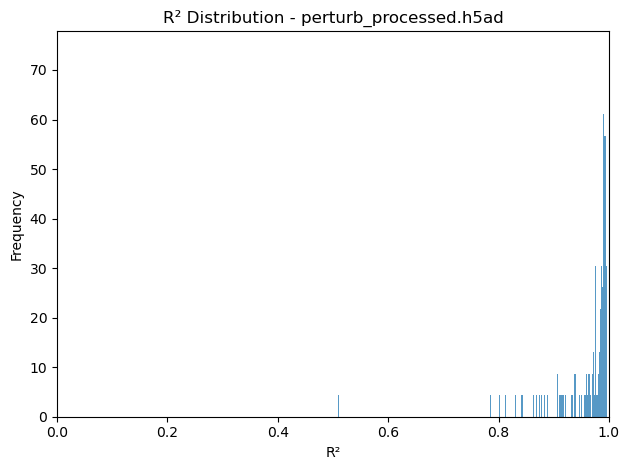

 60%|██████████████████████████▍                 | 6/10 [06:30<05:34, 83.65s/it]

peak_memory_GB =  5.41534423828125
=== Running on ./split_outputs/ReplogleWeissman2022_rpe1_splits/split_6/perturb_processed.h5ad ===
training
Epoch 01 | Total: 15.9416 | Recon: 0.2465 | Cls: 6.6026 | KL: 9.0925
Epoch 02 | Total: 7.4777 | Recon: 0.0968 | Cls: 6.5324 | KL: 0.8484
Epoch 03 | Total: 6.8242 | Recon: 0.0446 | Cls: 6.4972 | KL: 0.2824
Epoch 04 | Total: 6.6215 | Recon: 0.0235 | Cls: 6.4637 | KL: 0.1344
Epoch 05 | Total: 6.5311 | Recon: 0.0150 | Cls: 6.4270 | KL: 0.0891
Epoch 06 | Total: 6.4813 | Recon: 0.0120 | Cls: 6.3969 | KL: 0.0724
Epoch 07 | Total: 6.4411 | Recon: 0.0108 | Cls: 6.3636 | KL: 0.0667
Epoch 08 | Total: 6.4169 | Recon: 0.0102 | Cls: 6.3419 | KL: 0.0648
Epoch 09 | Total: 6.3965 | Recon: 0.0099 | Cls: 6.3223 | KL: 0.0643
Epoch 10 | Total: 6.3764 | Recon: 0.0096 | Cls: 6.3024 | KL: 0.0644
Epoch 11 | Total: 6.3579 | Recon: 0.0095 | Cls: 6.2836 | KL: 0.0648
Epoch 12 | Total: 6.3400 | Recon: 0.0094 | Cls: 6.2652 | KL: 0.0654
Epoch 13 | Total: 6.3282 | Recon: 0.0093

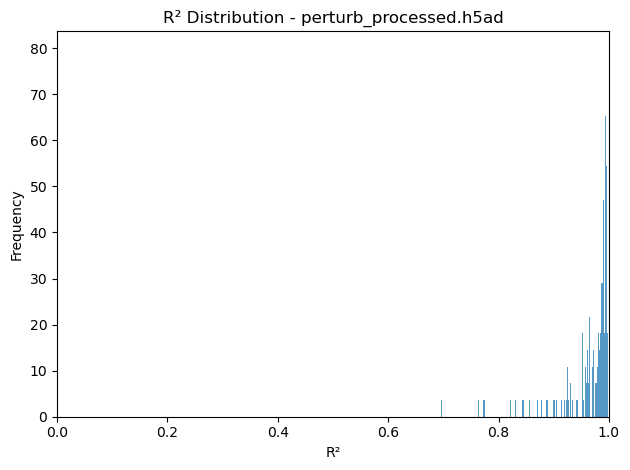

 70%|██████████████████████████████             | 7/10 [08:53<05:09, 103.02s/it]

peak_memory_GB =  5.41534423828125
=== Running on ./split_outputs/ReplogleWeissman2022_rpe1_splits/split_7/perturb_processed.h5ad ===
training
Epoch 01 | Total: 16.0615 | Recon: 0.2317 | Cls: 6.7239 | KL: 9.1060
Epoch 02 | Total: 7.4417 | Recon: 0.0824 | Cls: 6.6643 | KL: 0.6950
Epoch 03 | Total: 6.8788 | Recon: 0.0371 | Cls: 6.6302 | KL: 0.2115
Epoch 04 | Total: 6.7204 | Recon: 0.0198 | Cls: 6.5942 | KL: 0.1065
Epoch 05 | Total: 6.6493 | Recon: 0.0138 | Cls: 6.5602 | KL: 0.0752
Epoch 06 | Total: 6.5989 | Recon: 0.0117 | Cls: 6.5211 | KL: 0.0661
Epoch 07 | Total: 6.5719 | Recon: 0.0107 | Cls: 6.4977 | KL: 0.0635
Epoch 08 | Total: 6.5466 | Recon: 0.0102 | Cls: 6.4737 | KL: 0.0628
Epoch 09 | Total: 6.5298 | Recon: 0.0099 | Cls: 6.4569 | KL: 0.0630
Epoch 10 | Total: 6.5078 | Recon: 0.0096 | Cls: 6.4346 | KL: 0.0636
Epoch 11 | Total: 6.4905 | Recon: 0.0095 | Cls: 6.4167 | KL: 0.0642
Epoch 12 | Total: 6.4754 | Recon: 0.0094 | Cls: 6.4009 | KL: 0.0652
Epoch 13 | Total: 6.4630 | Recon: 0.0092

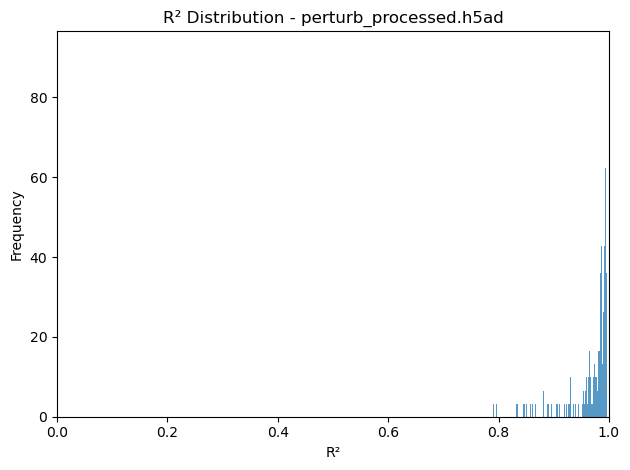

 80%|██████████████████████████████████▍        | 8/10 [11:44<04:09, 124.60s/it]

peak_memory_GB =  5.8829345703125
=== Running on ./split_outputs/ReplogleWeissman2022_rpe1_splits/split_8/perturb_processed.h5ad ===
training
Epoch 01 | Total: 15.4193 | Recon: 0.2257 | Cls: 6.8424 | KL: 8.3512
Epoch 02 | Total: 7.4789 | Recon: 0.0746 | Cls: 6.7835 | KL: 0.6207
Epoch 03 | Total: 6.9588 | Recon: 0.0319 | Cls: 6.7387 | KL: 0.1882
Epoch 04 | Total: 6.8050 | Recon: 0.0173 | Cls: 6.6938 | KL: 0.0939
Epoch 05 | Total: 6.7422 | Recon: 0.0128 | Cls: 6.6612 | KL: 0.0682
Epoch 06 | Total: 6.7020 | Recon: 0.0112 | Cls: 6.6293 | KL: 0.0615
Epoch 07 | Total: 6.6700 | Recon: 0.0104 | Cls: 6.6004 | KL: 0.0592
Epoch 08 | Total: 6.6459 | Recon: 0.0100 | Cls: 6.5776 | KL: 0.0583
Epoch 09 | Total: 6.6261 | Recon: 0.0097 | Cls: 6.5584 | KL: 0.0580
Epoch 10 | Total: 6.6072 | Recon: 0.0095 | Cls: 6.5397 | KL: 0.0579
Epoch 11 | Total: 6.5866 | Recon: 0.0094 | Cls: 6.5190 | KL: 0.0582
Epoch 12 | Total: 6.5780 | Recon: 0.0093 | Cls: 6.5098 | KL: 0.0589
Epoch 13 | Total: 6.5626 | Recon: 0.0092 

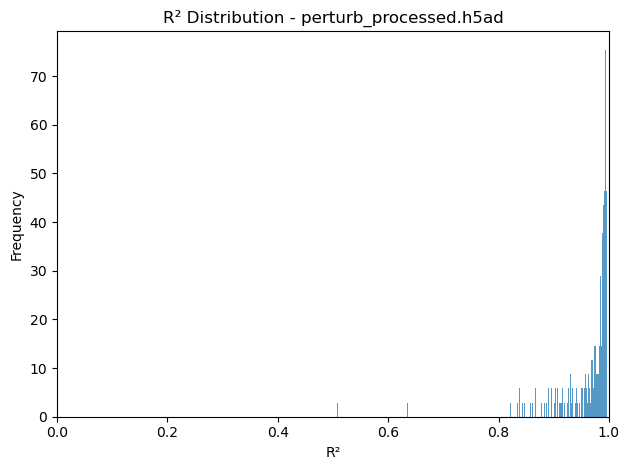

 90%|██████████████████████████████████████▋    | 9/10 [14:56<02:25, 145.84s/it]

peak_memory_GB =  5.8829345703125
=== Running on ./split_outputs/ReplogleWeissman2022_rpe1_splits/split_9/perturb_processed.h5ad ===
training
Epoch 01 | Total: 14.3304 | Recon: 0.2113 | Cls: 6.9372 | KL: 7.1819
Epoch 02 | Total: 7.3550 | Recon: 0.0616 | Cls: 6.8818 | KL: 0.4116
Epoch 03 | Total: 6.9855 | Recon: 0.0241 | Cls: 6.8379 | KL: 0.1235
Epoch 04 | Total: 6.8769 | Recon: 0.0139 | Cls: 6.7929 | KL: 0.0701
Epoch 05 | Total: 6.8258 | Recon: 0.0113 | Cls: 6.7556 | KL: 0.0589
Epoch 06 | Total: 6.7887 | Recon: 0.0103 | Cls: 6.7226 | KL: 0.0558
Epoch 07 | Total: 6.7609 | Recon: 0.0099 | Cls: 6.6962 | KL: 0.0548
Epoch 08 | Total: 6.7407 | Recon: 0.0096 | Cls: 6.6766 | KL: 0.0544
Epoch 09 | Total: 6.7171 | Recon: 0.0094 | Cls: 6.6533 | KL: 0.0544
Epoch 10 | Total: 6.6974 | Recon: 0.0093 | Cls: 6.6335 | KL: 0.0545
Epoch 11 | Total: 6.6839 | Recon: 0.0092 | Cls: 6.6196 | KL: 0.0551
Epoch 12 | Total: 6.6690 | Recon: 0.0091 | Cls: 6.6038 | KL: 0.0561
Epoch 13 | Total: 6.6545 | Recon: 0.0091 

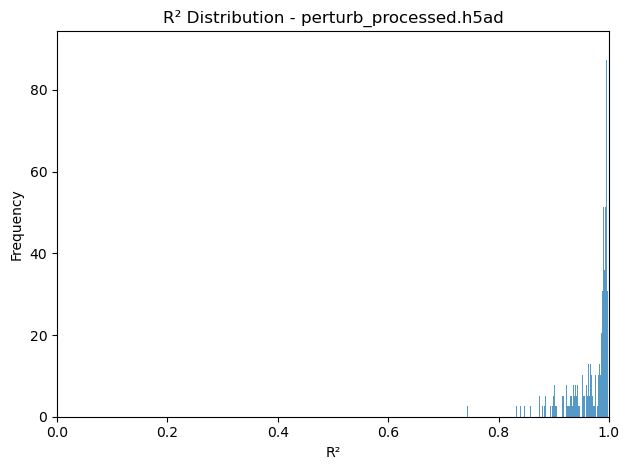

100%|██████████████████████████████████████████| 10/10 [18:16<00:00, 109.62s/it]

peak_memory_GB =  7.12432861328125
✅ Saved summary to CPA_VAE_split_results_summary_ReplogleWeissman2022_rpe1.csv


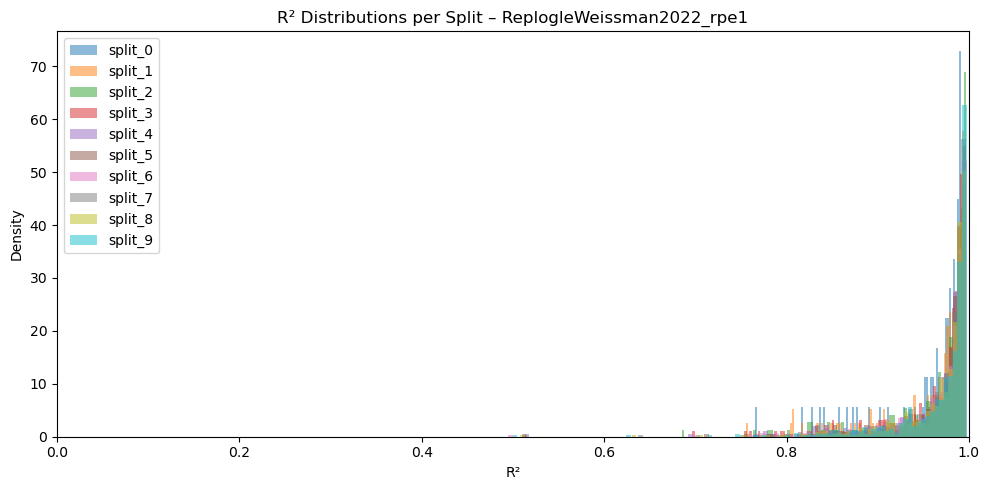

In [2]:
import os
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

# === Change this to match your output directory ===
dataset_name = "ReplogleWeissman2022_rpe1"  # or "ReplogleWeissman2022_K562_essential"
split_dir = f"./split_outputs/{dataset_name}_splits"
split_files = sorted(glob(os.path.join(split_dir, "split_*/perturb_processed.h5ad")))

# === To collect all results ===
all_results = []

for split_file in tqdm(split_files):
    try:
        result = train_and_evaluate_dataset(split_file)
        result["split"] = os.path.basename(os.path.dirname(split_file))
        all_results.append(result)
    except Exception as e:
        print(f"❌ Error processing {split_file}: {e}")

# === Save summary ===
os.makedirs("r2_distributions", exist_ok=True)
summary_df = pd.DataFrame(all_results)
summary_file = f"CPA_VAE_split_results_summary_{dataset_name}.csv"
summary_df.to_csv(summary_file, index=False)
print(f"✅ Saved summary to {summary_file}")

# === Optional: overlay all split R² histograms ===
plt.figure(figsize=(10, 5))
for r in all_results:
    plt.hist(r["all_r2"], bins=100, alpha=0.5, label=r["split"], density=True)
plt.xlim(0, 1)
plt.xlabel("R²")
plt.ylabel("Density")
plt.legend()
plt.title(f"R² Distributions per Split – {dataset_name}")
plt.tight_layout()
plt.savefig(f"r2_distributions/CPA_VAE_{dataset_name}_r2_overlay.png")
plt.show()


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

os.makedirs("plots", exist_ok=True)

# === Choose dataset ===
dataset = "ReplogleWeissman2022_rpe1"  # or "ReplogleWeissman2022_K562_essential"
result_path = f"CPA_VAE_split_results_summary_{dataset}.csv"
split_summary_path = f"split_outputs/{dataset}_splits/adata_summary.csv"

# === Load CSVs ===
results_df = pd.read_csv(result_path)
summary_df = pd.read_csv(split_summary_path)

# === Merge to get #cells per split ===
merged_df = pd.merge(results_df, summary_df[["split", "n_obs"]], on="split")

# === Plot R² vs Number of Cells ===
plt.figure(figsize=(6, 4))
plt.plot(merged_df["n_obs"], merged_df["avg_r2"], 'o-', color='skyblue')
plt.xlabel("Number of Cells in Split")
plt.ylabel("Average R²")
plt.title(f"R² vs Cell Count – {dataset}")
plt.tight_layout()
plt.savefig(f"plots/{dataset}_r2_vs_cells.png")
plt.show()

# === Plot Training Time vs Number of Cells ===
plt.figure(figsize=(6, 4))
plt.plot(merged_df["n_obs"], merged_df["train_time_sec"], 'o-', color='salmon')
plt.xlabel("Number of Cells in Split")
plt.ylabel("Training Time (sec)")
plt.title(f"Training Time vs Cell Count – {dataset}")
plt.tight_layout()
plt.savefig(f"plots/{dataset}_train_time_vs_cells.png")
plt.show()

# === Plot Memory Use vs Number of Cells ===
plt.figure(figsize=(6, 4))
plt.plot(merged_df["n_obs"], merged_df["peak_memory_GB"], 'o-', color='lightgreen')
plt.xlabel("Number of Cells in Split")
plt.ylabel("Peak Memory (GB)")
plt.title(f"Memory vs Cell Count – {dataset}")
plt.tight_layout()
plt.savefig(f"plots/{dataset}_memory_vs_cells.png")
plt.show()








In [ ]:
os.makedirs("plots", exist_ok=True)
import pandas as pd
import matplotlib.pyplot as plt

# === Load results from CSV ===
results_df = pd.read_csv("CPA_VAE_results_summary.csv")

# === Plot average R² per dataset ===
plt.figure(figsize=(6, 4))
plt.bar(results_df["dataset"], results_df["avg_r2"], color='skyblue')
plt.ylabel("Average R²")
plt.title("Average R² per Dataset")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("plots/avg_r2_per_dataset.png")
plt.show()

# === Plot training time per dataset ===
plt.figure(figsize=(6, 4))
plt.bar(results_df["dataset"], results_df["train_time_sec"], color='salmon')
plt.ylabel("Training Time (sec)")
plt.title("Training Time per Dataset")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("plots/train_time_per_dataset.png")
plt.show()

# === Plot peak memory use per dataset ===
plt.figure(figsize=(6, 4))
plt.bar(results_df["dataset"], results_df["peak_memory_GB"], color='lightgreen')
plt.ylabel("Peak Memory (GB)")
plt.title("Peak Memory per Dataset")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("plots/memory_per_dataset.png")
plt.show()
